# Problem 7.3

**Integrated Energy Grids**


**Problem 7.3**

**Assume that we have three locations (1,2,3) with an electric bus and a heating bus. The electricity loads are [0, 10, 20] MWh and the heating loads are [30, 20, 10] MWh. The electric buses are connected with transmission lines in a ring and there is a gas power generator at node 1 with an efficiency of 0.3 and a marginal cost of 50 EUR/MWh. At each location the electric and heating buses are connected with heat pumps with a coefficient of performance (COP) of 3; heat can also be supplied to every heat bus with a gas boiler with an efficiency of 0.9 and a marginal cost of 20 EUR/MWh.** 

**(a) Calculate the optimal heat generation by every component and the optical power flowing through the lines.**

**(b) Repeat (a) assuming that the marginal cost of heat pumps is 10 EUR/MWh.**

_Note: This problem is based on the PyPSA example [LOPF with coupling to heating sector](https://pypsa.readthedocs.io/en/stable/examples/lopf-with-heating.html)._

:::{note}
If you have not yet set up Python on your computer, you can execute this tutorial in your browser via [Google Colab](https://colab.research.google.com/). Click on the rocket in the top right corner and launch "Colab". If that doesn't work download the `.ipynb` file and import it in [Google Colab](https://colab.research.google.com/).

Then install the following packages by executing the following command in a Jupyter cell at the top of the notebook.

```sh
!pip install numpy pypsa
```
:::

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pypsa

Set parameter Username
Set parameter LicenseID to value 2767832
Academic license - for non-commercial use only - expires 2027-01-20


We start by building the network object that will contain the optimization problem

In [2]:
network = pypsa.Network()

Add three buses of AC and heat carrier each

In [3]:
for i in range(3):
    network.add("Bus", f"electric bus {i}", v_nom=20.0)
    network.add("Bus", f"heat bus {i}", carrier="heat")
network.buses

,v_nom,type,x,y,carrier,unit,location,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,generator,sub_network
name,,,,,,,,,,,,,
electric bus 0,20.0,,0.0,0.0,AC,,,1.0,0.0,inf,PQ,,
heat bus 0,1.0,,0.0,0.0,heat,,,1.0,0.0,inf,PQ,,
electric bus 1,20.0,,0.0,0.0,AC,,,1.0,0.0,inf,PQ,,
heat bus 1,1.0,,0.0,0.0,heat,,,1.0,0.0,inf,PQ,,
electric bus 2,20.0,,0.0,0.0,AC,,,1.0,0.0,inf,PQ,,
heat bus 2,1.0,,0.0,0.0,heat,,,1.0,0.0,inf,PQ,,


Now, we add three transmission lines in a ring

In [4]:
for i in range(3):
    network.add(
        "Line",
        f"line {i}",
        bus0=f"electric bus {i}",
        bus1=f"electric bus {(i + 1) % 3}",
        x=0.1,
        s_nom=1000,
    )
network.lines

,bus0,bus1,type,x,r,g,b,s_nom,s_nom_mod,s_nom_extendable,...,v_ang_min,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu,x_pu_eff,r_pu_eff,s_nom_opt
name,,,,,,,,,,,,,,,,,,,,,
line 0,electric bus 0,electric bus 1,,0.1,0.0,0.0,0.0,1000.0,0.0,False,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
line 1,electric bus 1,electric bus 2,,0.1,0.0,0.0,0.0,1000.0,0.0,False,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
line 2,electric bus 2,electric bus 0,,0.1,0.0,0.0,0.0,1000.0,0.0,False,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We connect every electricity bus to its corresponding heat bus using a heat pump with Coefficient of Performance (COP) 3

In [5]:
for i in range(3):
    network.add(
        "Link",
        f"heat pump {i}",
        bus0=f"electric bus {i}",
        bus1=f"heat bus {i}",
        p_nom=100,
        efficiency=3.0,
    )
    
network.links

,bus0,bus1,type,carrier,efficiency,active,build_year,lifetime,p_nom,p_nom_mod,...,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt
name,,,,,,,,,,,,,,,,,,,,,
heat pump 0,electric bus 0,heat bus 0,,,3.0,True,0,inf,100.0,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
heat pump 1,electric bus 1,heat bus 1,,,3.0,True,0,inf,100.0,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
heat pump 2,electric bus 2,heat bus 2,,,3.0,True,0,inf,100.0,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0


We add a gas generator at electric bus 0 and a boiler at all heat buses

In [6]:
network.add(
    "Generator",
    "gas generator",
    bus="electric bus 0",
    p_nom=100,
    marginal_cost=50,
    efficiency=0.3,
)

for i in range(3):
    network.add(
        "Generator",
        f"boiler {i}",
        bus=f"heat bus {i}",
        p_nom=1000,
        efficiency=0.9,
        marginal_cost=20.0,
        carrier="gas",
    )

network.generators

,bus,control,type,p_nom,p_nom_mod,p_nom_extendable,p_nom_min,p_nom_max,p_nom_set,p_min_pu,...,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt
name,,,,,,,,,,,,,,,,,,,,,
gas generator,electric bus 0,PQ,,100.0,0.0,False,0.0,inf,NaN,0.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
boiler 0,heat bus 0,PQ,,1000.0,0.0,False,0.0,inf,NaN,0.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
boiler 1,heat bus 1,PQ,,1000.0,0.0,False,0.0,inf,NaN,0.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
boiler 2,heat bus 2,PQ,,1000.0,0.0,False,0.0,inf,NaN,0.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0


Add electric loads and heat loads.

In [7]:
for i in range(3):
    network.add(
        "Load",
        f"electric load {i}",
        bus=f"electric bus {i}",
        p_set=i * 10,
    )

for i in range(3):
    network.add(
        "Load",
        f"heat load {i}",
        bus=f"heat bus {i}",
        p_set=(3 - i) * 10,
    )

network.loads

,bus,carrier,type,p_set,q_set,sign,active
name,,,,,,,
electric load 0,electric bus 0,,,0.0,0.0,-1.0,True
electric load 1,electric bus 1,,,10.0,0.0,-1.0,True
electric load 2,electric bus 2,,,20.0,0.0,-1.0,True
heat load 0,heat bus 0,,,30.0,0.0,-1.0,True
heat load 1,heat bus 1,,,20.0,0.0,-1.0,True
heat load 2,heat bus 2,,,10.0,0.0,-1.0,True


In [8]:
network.optimize()

Index(['electric bus 0', 'heat bus 0', 'electric bus 1', 'heat bus 1',
       'electric bus 2', 'heat bus 2'],
      dtype='object', name='name')
Index(['boiler 0', 'boiler 1', 'boiler 2'], dtype='object', name='name')
Index(['heat pump 0', 'heat pump 1', 'heat pump 2'], dtype='object', name='name')
Index(['line 0', 'line 1', 'line 2'], dtype='object', name='name')
Index(['line 0', 'line 1', 'line 2'], dtype='object', name='name')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.59s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 10 primals, 27 duals
Objective: 2.50e+03
Solver model: available
Solver message: Optimal



Running HiGHS 1.12.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP linopy-problem-uolxb8d7 has 27 rows; 10 cols; 39 nonzeros
Coefficient ranges:
  Matrix  [1e+00, 2e+01]
  Cost    [2e+01, 5e+01]
  Bound   [0e+00, 0e+00]
  RHS     [1e+01, 1e+03]
Presolving model
4 rows, 7 cols, 13 nonzeros  0s
3 rows, 6 cols, 11 nonzeros  0s
2 rows, 5 cols, 7 nonzeros  0s
1 rows, 4 cols, 4 nonzeros  0s
0 rows, 0 cols, 0 nonzeros  0s
Presolve reductions: rows 0(-27); columns 0(-10); nonzeros 0(-39) - Reduced to empty
Performed postsolve
Solving the original LP from the solution after postsolve

Model name          : linopy-problem-uolxb8d7
Model status        : Optimal
Objective value     :  2.5000000000e+03
P-D objective error :  9.0931283921e-17
HiGHS run time      :          0.00


INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Line-fix-s-lower, Line-fix-s-upper, Link-fix-p-lower, Link-fix-p-upper, Kirchhoff-Voltage-Law were not assigned to the network.


('ok', 'optimal')

We can calculate and plot the energy produced by every boiler, heat pumps and trasmitted through the lines

In [9]:
demands = network.loads_t.p.loc["now"]
generators =  network.generators_t.p.loc["now"]
links = network.links_t.p0.loc["now"]
lines = network.lines_t.p0.loc["now"]

<Axes: xlabel='name'>

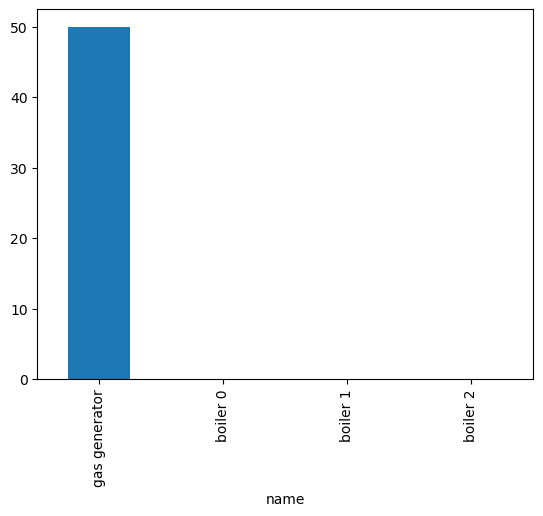

In [10]:
generators.plot.bar()

<Axes: xlabel='name'>

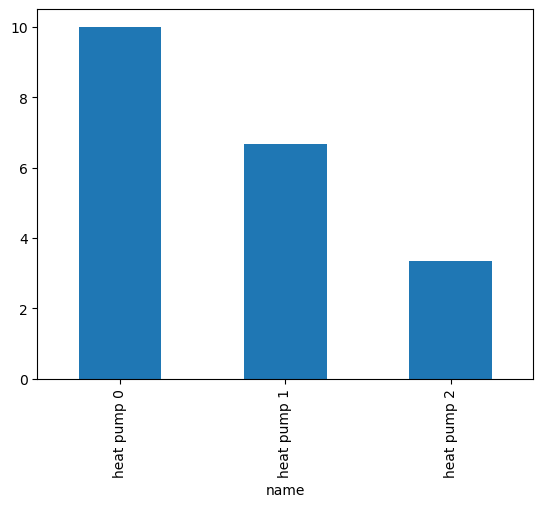

In [11]:
links.plot.bar()

<Axes: xlabel='name'>

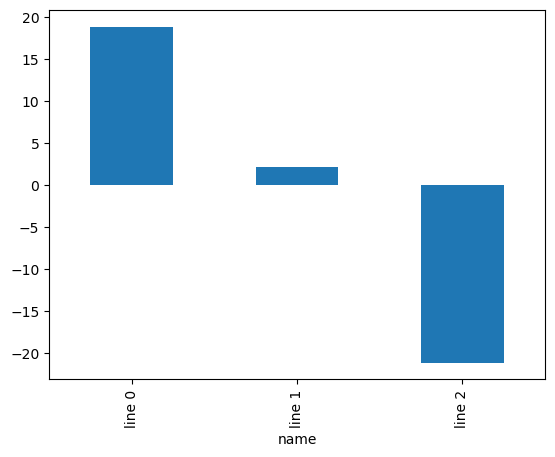

In [12]:
lines.plot.bar()

**(b) Repeat (a) assuming that the marginal cost of heat pumps is 10 EUR/MWh.**

We update the marginal cost of heat pumps and redo the optimization

In [13]:
network.links.marginal_cost = 10

In [14]:
network.optimize()

demands = network.loads_t.p.loc["now"]
generators =  network.generators_t.p.loc["now"]
links = network.links_t.p0.loc["now"]
lines = network.lines_t.p0.loc["now"]

Index(['electric bus 0', 'heat bus 0', 'electric bus 1', 'heat bus 1',
       'electric bus 2', 'heat bus 2'],
      dtype='object', name='name')
Index(['boiler 0', 'boiler 1', 'boiler 2'], dtype='object', name='name')
Index(['heat pump 0', 'heat pump 1', 'heat pump 2'], dtype='object', name='name')
Index(['line 0', 'line 1', 'line 2'], dtype='object', name='name')
Index(['line 0', 'line 1', 'line 2'], dtype='object', name='name')
Index(['0'], dtype='object', name='name')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.51s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 10 primals, 27 duals
Objective: 2.70e+03
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Line-fix-s-lower, Line-fix-s-upper, Link-fix-p-lower, Link-fix-p-upper, Kirchhoff-Voltage-Law were not assigned to the network.


Running HiGHS 1.12.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP linopy-problem-dg83ga85 has 27 rows; 10 cols; 39 nonzeros
Coefficient ranges:
  Matrix  [1e+00, 2e+01]
  Cost    [1e+01, 5e+01]
  Bound   [0e+00, 0e+00]
  RHS     [1e+01, 1e+03]
Presolving model
4 rows, 7 cols, 13 nonzeros  0s
3 rows, 6 cols, 11 nonzeros  0s
2 rows, 5 cols, 7 nonzeros  0s
1 rows, 4 cols, 4 nonzeros  0s
0 rows, 0 cols, 0 nonzeros  0s
Presolve reductions: rows 0(-27); columns 0(-10); nonzeros 0(-39) - Reduced to empty
Performed postsolve
Solving the original LP from the solution after postsolve

Model name          : linopy-problem-dg83ga85
Model status        : Optimal
Objective value     :  2.7000000000e+03
P-D objective error :  0.0000000000e+00
HiGHS run time      :          0.00


<Axes: xlabel='name'>

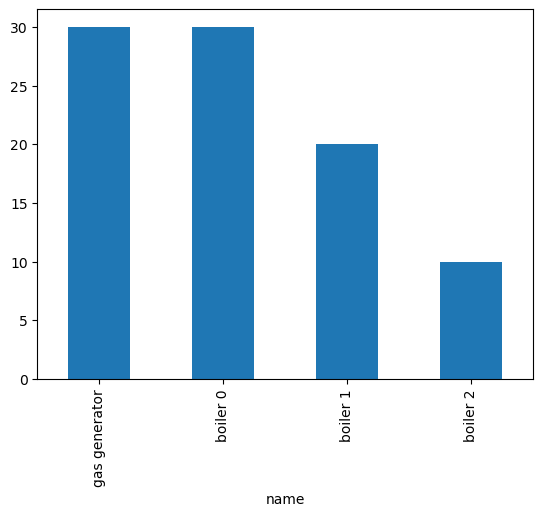

In [15]:
generators.plot.bar()


<Axes: xlabel='name'>

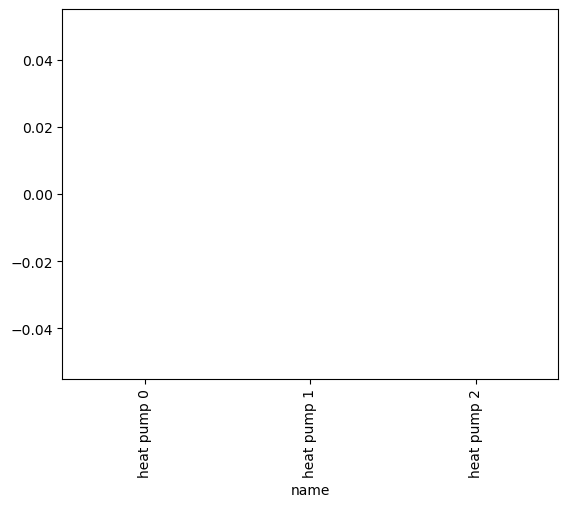

In [16]:
links.plot.bar()

<Axes: xlabel='name'>

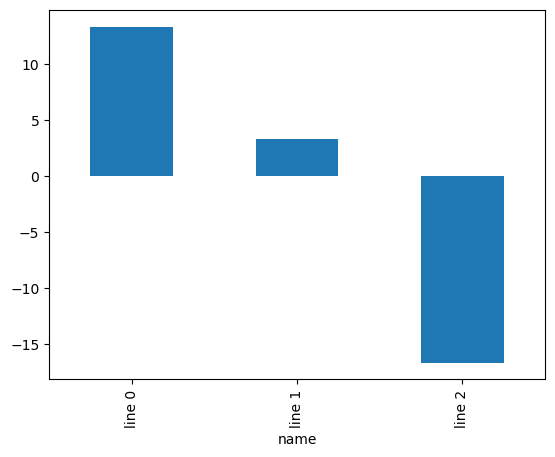

In [17]:
lines.plot.bar()